In [1]:
%matplotlib inline

import stumpy
import numpy as np
import matplotlib.pyplot as plt
import urllib
import ssl
import io
import os
import time
import zipfile
from scipy.io import loadmat
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.special import comb
from itertools import combinations

Ostinato using pre-computed FFTs. Functions `rolling_window`, `moving_average` and `moving_std` were copied verbatim, `find_nearest` heavily inspired by `massv2` of mass-ts toolbox.

In [2]:
def nextpow2(x): 
    return np.ceil(np.log2(np.abs(x)))


def rolling_window(a, window):
    """
    Provides a rolling window on a numpy array given an array and window size.
    Parameters
    ----------
    a : array_like
        The array to create a rolling window on.
    window : int
        The window size.
    Returns
    -------
    Strided array for computation.
    """
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def moving_average(a, window=3):
    """
    Computes the moving average over an array given a window size.
    Parameters
    ----------
    a : array_like
        The array to compute the moving average on.
    window : int
        The window size.
    Returns
    -------
    The moving average over the array.
    """
    return np.mean(rolling_window(a, window), -1)


def moving_std(a, window=3):
    """
    Computes the moving std. over an array given a window size.
    Parameters
    ----------
    a : array_like
        The array to compute the moving std. on.
    window : int
        The window size.
    Returns
    -------
    The moving std. over the array.
    """
    return np.std(rolling_window(a, window), -1)



class ConsensusSearch():
    def __init__(self, tss, m):
        self.tss = tss
        self.m = m
        self.k = len(tss)
        self.ffts = None
        self._compute_ffts()
        self.mus = None
        self._compute_means()
        self.sigmas = None
        self._compute_sigmas()
        self.bsf = 2 * np.sqrt(m)
        self.ts_ind = 0
        self.ss_ind = 0
        
    def _compute_ffts(self):
        if self.ffts is None:
            self.ffts = [np.fft.fft(ts, int(2**nextpow2(len(ts)))) for ts in self.tss]
    
    def _compute_means(self):
        if self.mus is None:
            self.mus = []
            for ts in self.tss:
                mu = moving_average(ts, self.m)
                mu = np.append(np.ones((1, len(ts) - len(mu))), mu)
                self.mus.append(mu)
            
    def _compute_sigmas(self):
        if self.sigmas is None:
            self.sigmas = []
            for ts in self.tss:
                sigma = moving_std(ts, self.m)
                sigma = np.append(np.zeros((1, len(ts) - len(sigma))), sigma)
                self.sigmas.append(sigma)
                
    def solve(self):
        for i_a in range(self.k):
            if i_a < (self.k - 1):
                i_b = i_a + 1
            else:
                i_b = 0
            # AB join
            mp = stumpy.stump(self.tss[i_a], self.m, self.tss[i_b], ignore_trivial=False)
            # sort by distances
            si = np.argsort(mp[:, 0])
            for i_q in si:
                rad = mp[i_q, 0]
                # If the smallest distance in this AB join is greater than the
                # best so far value, there is no chance of distances to other
                # time-series' subsequences being smaller
                if rad >= self.bsf:
                    break
                query = self.tss[i_a][i_q:i_q+self.m]
                
                # loop over remaining time-series
                for i in range(self.k):
                    if ~np.isin(i, [i_a, i_b]):
                        rad = np.max((
                                rad, 
                                np.min(self.findnearest(i, query))))
                        # If the smallest distance to this remaining time-series
                        # is greater then the best so far value, checking the other
                        # remaining time-series won't find a better one
                        if rad >= self.bsf:
                            break
                # update best so far value if better radius was found
                if rad < self.bsf:
                    self.bsf = rad
                    self.ts_ind = i_a
                    self.ss_ind = i_q
    
    def findnearest(self, i, query):
        m = self.m
        n = len(self.tss[i])
        meanx = self.mus[i]
        sigmax = self.sigmas[i]
        y = query
        meany = np.mean(y)
        sigmay = np.std(y)
        
        X = self.ffts[i]
        Y = np.fft.fft(np.flip(y), len(X))
        Y.resize(X.shape)
        Z = X * Y
        z = np.fft.ifft(Z)
        
        dist = 2 * (m - (z[m - 1:n] - m * meanx[m - 1:n] * meany) / 
                    (sigmax[m - 1:n] * sigmay))
        dist = np.abs(np.sqrt(dist))
        
        return dist

Retrieve the mtDNA data.

In [3]:
context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity
T_url = 'https://sites.google.com/site/consensusmotifs/dna.zip?attredirects=0&d=1'
T_raw_bytes = urllib.request.urlopen(T_url, context=context).read()
T_data = io.BytesIO(T_raw_bytes)
T_zipfile = zipfile.ZipFile(T_data)
animals = ['python', 'hippo', 'red_flying_fox', 'alpaca']
data = {}
for a in animals:
    with T_zipfile.open(f'dna/data/{a}.mat') as f:
        data[a] = loadmat(f)['ts'].flatten().astype(float)

colors = {'python': 'tab:blue', 'hippo': 'tab:green', 'red_flying_fox': 'tab:purple', 'alpaca': 'tab:red'}

Clustering obtained from using majority of mtDNA sequences. The paper says that they truncated to 16000 data points but to reproduce the sequences in Fig. 9 left they need to be truncated to 15000.

To reproduce the clustering the standardised euclidean distance has to be used.

Text(0, 0.5, 'standardised euclidean distance')

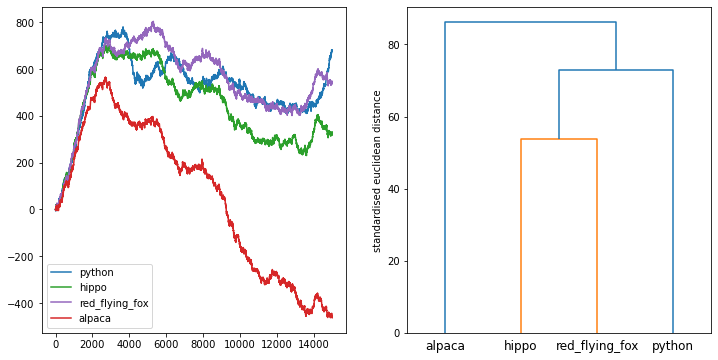

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# sequences in Fig 9 left
truncate = 15000
for k, v in data.items():
    ax[0].plot(v[:truncate], label=k, color=colors[k])
ax[0].legend()

# clustering in Fig 9 left
truncate = 16000
dp = np.zeros(int(comb(4, 2)))
for i, a_c in enumerate(combinations(data.keys(), 2)):
    dp[i] = stumpy.core.mass(data[a_c[0]][:truncate], data[a_c[1]][:truncate])
Z = linkage(dp, optimal_ordering=True)
dendrogram(Z, labels=[k for k in data.keys()], ax=ax[1])
ax[1].set_ylabel('standardised euclidean distance')

Do the consensus motif search.

In [5]:
m = 1000
cs = ConsensusSearch([ts for ts in data.values()], m)
t = time.time()
cs.solve()
print(f'{time.time()-t} s to find consensus sequence')
ts_ind = cs.ts_ind
ss_ind = cs.ss_ind

16.176260709762573 s to find consensus sequence


Get the consensus motifs and perform clustering on them.

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [20.0, 20.0, 35.0, 35.0],
  [5.0, 5.0, 27.5, 27.5]],
 'dcoord': [[0.0, 2.0617336442321275, 2.0617336442321275, 0.0],
  [2.0617336442321275, 2.3864893853904543, 2.3864893853904543, 0.0],
  [0.0, 2.731288881859224, 2.731288881859224, 2.3864893853904543]],
 'ivl': ['python', 'alpaca', 'hippo', 'red_flying_fox'],
 'leaves': [0, 3, 1, 2],
 'color_list': ['C0', 'C0', 'C0']}

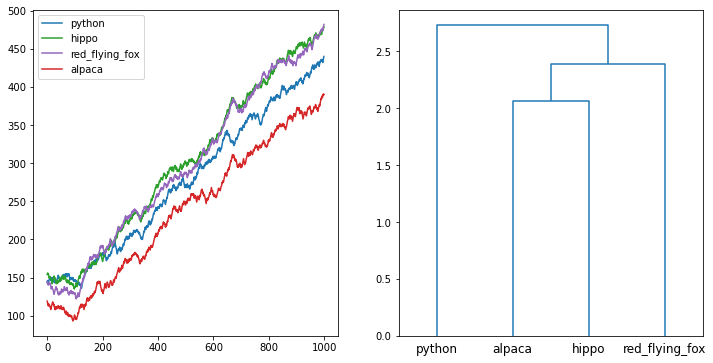

In [6]:
consensus_motifs = {}
best_motif = list(data.items())[ts_ind][1][ss_ind:ss_ind+m]
for i, (k, v) in enumerate(data.items()):
    if i == ts_ind:
        consensus_motifs[k] = best_motif
    else:
        ind = np.argmin(stumpy.core.mass(best_motif, v))
        consensus_motifs[k] = v[ind:ind+m]

        
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
# plot the consensus motifs
for animal, motif in consensus_motifs.items():
    ax[0].plot(motif, label=animal, color=colors[animal])
ax[0].legend()
# cluster consensus motifs
dp = np.zeros(int(comb(4, 2)))
for i, motif in enumerate(combinations(list(consensus_motifs.values()), 2)):
    dp[i] = stumpy.core.mass(motif[0], motif[1])
Z = linkage(dp, optimal_ordering=True)
dendrogram(Z, labels=[k for k in consensus_motifs.keys()])